<a href="https://colab.research.google.com/github/EmicoBinsfinder/GNN_Viscosity_Prediction/blob/main/DynamicViscosityPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN (Convolution and Attention Based) for Molecular Property Prediction (Regression)

* Google Colab
* RDKit
* PyTorch Geometric (PyG)

## Environment Preparation

instal rdkit and pyg

In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.6 MB/s eta 0:00:00


In [2]:
import torch
pyg_url = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $pyg_url

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=a7acfa31156038d5799e1451e74a98ccdedf3fec113dadd0f5eb87995c8ec930
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [3]:
!git clone https://github.com/EmicoBinsfinder/GNN_Viscosity_Prediction.git

Cloning into 'GNN_Viscosity_Prediction'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 38 (delta 7), reused 31 (delta 5), pack-reused 0
Receiving objects: 100% (38/38), 6.55 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (7/7), done.


import

In [4]:
import sys
import urllib.request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx


In [5]:
!curl -O https://raw.githubusercontent.com/itakigawa/mpl_rdkit_utils/main/mpl_rdkit_utils.py

from mpl_rdkit_utils import DrawMolToMPL

def plot_mol_graph(graph, figsize=(8, 4), edge_label=True):
  g = to_networkx(graph, to_undirected=True)
  edge_dict = defaultdict(list)
  for i, e in enumerate(zip(*graph.edge_index.tolist())):
    u, v = e
    edge_dict[(u, v)].append(i)
    edge_dict[(v, u)].append(i)
  labels = {e: "{},{}".format(*edge_dict[e]) for e in g.edges}

  mol = graph.mol
  AllChem.Compute2DCoords(mol)
  pos = mol.GetConformers()[0].GetPositions()[:,:2]

  fig, ax = plt.subplots(1, 2, figsize=figsize)
  node_size=300
  nx.draw_networkx(g, pos, ax=ax[0], node_color='#eee', \
                   node_size=node_size, edgecolors='k')
  if edge_label:
    nx.draw_networkx_edge_labels(g, pos, ax=ax[0], edge_labels=labels,\
                                font_color='blue', rotate=False)
  dpi = plt.rcParams["figure.dpi"]
  node_radius = (node_size / 3.14159265359)**0.5 / dpi
  ax[0].set_axis_off()
  ax[0].set_aspect('equal')
  xmin, xmax = ax[0].get_xlim()
  ymin, ymax = ax[0].get_ylim()
  fs = min(*figsize)
  xr = node_radius * fs
  yr = node_radius * fs
  ax[0].set_xlim(xmin-xr, xmax+xr)
  ax[0].set_ylim(ymin-yr, ymax+yr)

  (xmin, xmax), (ymin, ymax) = DrawMolToMPL(mol, fig, ax[1])
  ax[1].set_xlim(xmin, xmax)
  ax[1].set_ylim(ymin, ymax)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7540  100  7540    0     0  32334      0 --:--:-- --:--:-- --:--:-- 32360


# data loading

In [50]:
# Read in dataset from CSV file
df = pd.read_csv('/content/GNN_Viscosity_Prediction/Dataset.csv')

In [98]:
# Generating a list of number to assign IDs to each entry
ID_list = list(range(len(df)))
df['ID'] = ID_list

df = df[['smiles', 'ID', 'VI']]
df = df.loc[df['VI'] > 0]

#Shuffle Dataset

#Removing duplicates and entries with NaNs
df = df.dropna()
df = df.drop_duplicates()
df = df.sample(frac=1).reset_index(drop=True)

#Creating new CSV with target variable and it's SMILES string
df.to_csv('input.csv')

In [99]:
df.head()
len(df)

47534

In [100]:
# Reading in new Dataset
df = pd.read_csv('input.csv', index_col=0)

#Selecting random entry from Dataset
smi = df['smiles'][9314]

#Constructs a molecule object from a given SMILES string
mol = Chem.MolFromSmiles(smi)
print(type(mol))

<class 'rdkit.Chem.rdchem.Mol'>


In [64]:
smi

'C(C=CC1CCCCC1)CCCCC=CCCC=CCC'

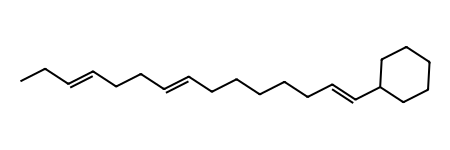

In [65]:
# Display plot of the SMILES string of a random entry from the dataset
mol

# molecular graphs for pyg

In [107]:
edges = []



for bond in mol.GetBonds():
  #Returns the index of the bond’s first atom
  i = bond.GetBeginAtomIdx()

  #Returns the index of the bond’s last atom
  j = bond.GetEndAtomIdx()

  #Add bonds (edges) to empty list as a list of bond tuples
  edges.extend([(i,j), (j,i)])

 first atom 0
1
 first atom 1
2
 first atom 2
3
 first atom 3
4
 first atom 4
5
 first atom 5
6
 first atom 6
7
 first atom 7
8
 first atom 8
9
 first atom 9
10
 first atom 0
11
 first atom 0
12
 first atom 12
13
 first atom 13
14
 first atom 14
15
 first atom 15
16
 first atom 15
17
 first atom 17
18
 first atom 18
19
 first atom 19
20
 first atom 20
21
 first atom 21
22
 first atom 22
23
 first atom 23
24
 first atom 24
25
 first atom 25
26
 first atom 26
27
 first atom 27
28
 first atom 28
29
 first atom 20
30
 first atom 30
31
 first atom 31
32
 first atom 32
33
 first atom 33
34
 first atom 34
35
 first atom 10
5
 first atom 35
30


In [68]:
edge_index = list(zip(*edges))

In [69]:
def atom_feature(atom):
  return [atom.GetAtomicNum(),
          atom.GetDegree(),
          atom.GetNumImplicitHs(),
          atom.GetIsAromatic()]

def bond_feature(bond):
  return [bond.GetBondType(),
          bond.GetStereo()]

In [70]:
node_features = [atom_feature(a) for a in mol.GetAtoms()]
edge_features = [bond_feature(b) for b in mol.GetBonds()]

In [71]:
g = Data(edge_index=torch.LongTensor(edge_index),
         x=torch.FloatTensor(node_features),
         edge_attr=torch.FloatTensor(edge_features),
         smiles=smi,
         mol=mol)

In [72]:
g

Data(x=[21, 4], edge_index=[2, 42], edge_attr=[21, 2], smiles='C(C=CC1CCCCC1)CCCCC=CCCC=CCC', mol=<rdkit.Chem.rdchem.Mol object at 0x7cb76186e810>)

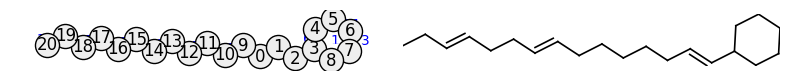

In [73]:
plot_mol_graph(g)

In [74]:
def smi_to_pyg(smi, y):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
      return None

    id_pairs = ((b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds())
    atom_pairs = [z for (i, j) in id_pairs for z in ((i, j), (j, i))]

    bonds = (mol.GetBondBetweenAtoms(i, j) for (i, j) in atom_pairs)
    atom_features = [atom_feature(a) for a in mol.GetAtoms()]
    bond_features = [bond_feature(b) for b in bonds]

    return Data(edge_index=torch.LongTensor(list(zip(*atom_pairs))),
                x=torch.FloatTensor(atom_features),
                edge_attr=torch.FloatTensor(bond_features),
                y=torch.LongTensor([y]),
                mol=mol,
                smiles=smi)

In [75]:
class MyDataset(Dataset):
  def __init__(self, smiles, response):
    mols = [smi_to_pyg(smi, y) for smi, y in \
            tqdm(zip(smiles, response), total=len(smiles))]
    self.X = [m for m in mols if m]

  def __getitem__(self, idx):
    return self.X[idx]

  def __len__(self):
    return len(self.X)

In [77]:
base_dataset = MyDataset(df['smiles'], df['VI'])

  0%|          | 0/54222 [00:00<?, ?it/s]

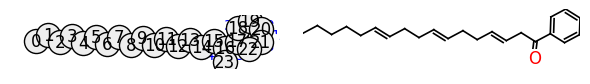

In [78]:
g = base_dataset[820]
plot_mol_graph(g, figsize=(6, 3), edge_label=True)

In [79]:
g

Data(x=[24, 4], edge_index=[2, 48], edge_attr=[48, 2], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7cb76186ef80>, smiles='CCCCCC=CCCC=CCCC=CCC(c1ccccc1)=O')

In [80]:
g.y

tensor([114])

# train/val/test split

In [81]:
N = len(base_dataset)
M = N // 10

indices = np.random.permutation(range(N))

idx = {'train': indices[:8*M],
      'valid': indices[8*M:9*M],
      'test': indices[9*M:]}

modes = ['train', 'valid', 'test']

In [82]:
dataset = {m: Subset(base_dataset, idx[m]) for m in modes}


loader = {m: DataLoader(dataset[m], batch_size=64, shuffle=True) if m == 'train' \
          else DataLoader(dataset[m], batch_size=64) for m in modes}

# gin & gatv2 with edge_attr

In [83]:
from torch_geometric.nn import GINEConv, GATv2Conv, global_add_pool

In [84]:
def MyConv(node_dim, edge_dim, arch='GAT'):
  conv = None
  if arch == 'GIN':
    h = nn.Sequential(nn.Linear(node_dim, node_dim, bias=True))
    conv = GINEConv(h, edge_dim=edge_dim)
  elif arch == 'GAT':
    conv = GATv2Conv(node_dim, node_dim, edge_dim=edge_dim)
  return conv

In [85]:
class MyGNN(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3):
    super().__init__()
    layers = [MyConv(node_dim, edge_dim, arch) for _ in range(num_layers)]
    self.convs = nn.ModuleList(layers)

  def forward(self, x, edge_index, edge_attr):
    for conv in self.convs:
      x = conv(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
    return x

In [86]:
[int(x) for x in Chem.rdchem.BondType.names.values()]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [87]:
ptable = Chem.GetPeriodicTable()
for i in range(200):
  try:
    s = ptable.GetElementSymbol(i)
  except:
    print(f'max id {i-1} for {s}')
    break
ptable.GetElementSymbol(i-1)

max id 118 for Og


[15:31:33] 

****
Pre-condition Violation
Atomic number not found
Violation occurred on line 99 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/PeriodicTable.h
Failed Expression: atomicNumber < byanum.size()
****



'Og'

In [88]:
class MyFinalNetwork(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3,
               encoding='onehot'):
    super().__init__()

    self.encoding = encoding
    if encoding != 'onehot':
      self.atom_encoder = nn.Embedding(num_embeddings=118+1, embedding_dim=64)
      self.bond_encoder = nn.Embedding(num_embeddings=21+1, embedding_dim=8)
      node_dim = (node_dim-1) + 64
      edge_dim = (edge_dim-1) + 8
    else:
      node_dim = (node_dim-1) + 118+1
      edge_dim = (edge_dim-1) + 21+1

    self.gnn = MyGNN(node_dim, edge_dim, arch, num_layers=num_layers)
    embed_dim = int(node_dim / 2)
    self.head = nn.Sequential(
        nn.BatchNorm1d(node_dim),
        nn.Dropout(p=0.5),
        nn.Linear(node_dim, embed_dim, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(embed_dim),
        nn.Dropout(p=0.5),
        nn.Linear(embed_dim, 1)
    )
  def forward(self, x, edge_index, edge_attr, batch):
    if self.encoding == 'onehot':
      x0 = F.one_hot(x[:, 0].to(torch.int64), num_classes=118+1)
      edge_attr0 = F.one_hot(edge_attr[:, 0].to(torch.int64), num_classes=21+1)
    else:
      x0 = self.atom_encoder(x[:, 0].int())
      edge_attr0 = self.bond_encoder(edge_attr[:, 0].int())

    x = torch.cat([x0, x[:, 1:]], dim=1)
    edge_attr = torch.cat([edge_attr0, edge_attr[:, 1:]], dim=1)

    node_out = self.gnn(x, edge_index, edge_attr)
    graph_out = global_add_pool(node_out, batch)
    return self.head(graph_out)

In [89]:
node_dim = base_dataset[0].num_node_features
edge_dim = base_dataset[0].num_edge_features
node_dim, edge_dim

(4, 2)

In [90]:
model = MyFinalNetwork(node_dim, edge_dim, arch='GAT', num_layers=3, encoding='embedding')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [91]:
train_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.MSELoss()

In [92]:
def train(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.unsqueeze(1).float())

        #Perform backpropagation
        loss.backward()

        #Perfom optimiser update
        optimizer.step()

        #Changes the learning rate depending on the learning rate pre-condition
        scheduler.step()
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def test(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.unsqueeze(1).float())
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        _, predicted = torch.max(out.data, 1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [93]:
best_val = float("inf")

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
        ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 001 Loss: train 224.592481 valid 203.264640 test 204.046586
Epoch: 002 Loss: train 175.024504 valid 139.342997 test 139.716328
Epoch: 003 Loss: train 107.405243 valid 72.799290 test 72.996148
Epoch: 004 Loss: train 45.764948 valid 23.849298 test 24.416444
Epoch: 005 Loss: train 18.102036 valid 14.986638 test 15.439303
Epoch: 006 Loss: train 14.753039 valid 14.845509 test 14.879251
Epoch: 007 Loss: train 14.280065 valid 14.423416 test 14.296978
Epoch: 008 Loss: train 14.051988 valid 14.377083 test 14.219888
Epoch: 009 Loss: train 14.294521 valid 14.203123 test 14.246826
Epoch: 010 Loss: train 13.973471 valid 14.336595 test 14.217402
Epoch: 011 Loss: train 13.931818 valid 14.378376 test 14.436621
Epoch: 012 Loss: train 13.905130 valid 14.032448 test 13.922858
Epoch: 013 Loss: train 13.626644 valid 13.567089 test 14.050681
Epoch: 014 Loss: train 13.636605 valid 13.721133 test 14.269975
Epoch: 015 Loss: train 13.547263 valid 13.717868 test 13.596306
Epoch: 016 Loss: train 13.459053 

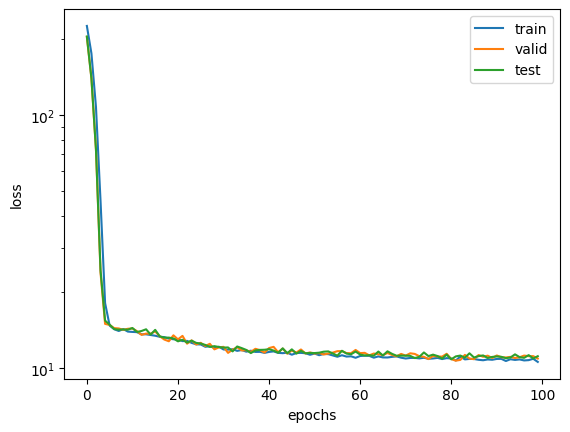

In [94]:
fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [95]:
@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        predicted = out
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [96]:
model.load_state_dict(torch.load('best_val.model'))
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true, y_pred = predict(loader[m])
print(y_true, y_pred)

for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  print(y_pred)
  for metric in [mean_absolute_error, mean_squared_error]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))

[130, 145, 125, 0, 159, 118, 127, 132, 123, 110, 0, 118, 160, 180, 146, 0, 57, 108, 161, 0, 105, 0, 136, 0, 165, 31, 105, 149, 158, 0, 117, 116, 146, 128, 100, 172, 134, 111, 152, 175, 112, 150, 166, 136, 143, 81, 135, 0, 163, 159, 124, 127, 154, 127, 134, 154, 139, 0, 93, 52, 113, 0, 113, 162, 105, 0, 141, 0, 148, 37, 173, 107, 0, 127, 0, 0, 124, 53, 46, 152, 173, 141, 121, 72, 0, 105, 115, 82, 141, 0, 127, 32, 188, 170, 103, 128, 154, 96, 0, 0, 134, 84, 0, 81, 0, 80, 89, 99, 89, 0, 122, 63, 142, 153, 124, 134, 160, 141, 98, 114, 150, 116, 144, 150, 0, 112, 46, 102, 139, 0, 188, 132, 103, 132, 162, 104, 118, 0, 158, 143, 165, 176, 65, 110, 136, 112, 134, 113, 68, 187, 156, 168, 125, 130, 58, 138, 95, 210, 151, 0, 139, 116, 148, 110, 159, 129, 131, 180, 108, 45, 141, 127, 130, 44, 128, 164, 0, 171, 89, 0, 174, 70, 166, 105, 178, 110, 163, 95, 165, 111, 0, 139, 149, 161, 123, 68, 0, 107, 123, 121, 168, 0, 162, 142, 0, 146, 150, 127, 129, 147, 130, 142, 23, 174, 120, 172, 152, 49, 96, 0,